In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [9]:
# Define the paths to your uploaded datasets on Kaggle
train_folder = '/kaggle/input/braille-dataset-punjabi-in-png/image dataset/Organised_Training_Set'
val_folder = '/kaggle/input/braille-dataset-punjabi-in-png/image dataset/Organised_Validation_Set'

In [11]:
# ImageDataGenerator setup for loading and augmenting images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [12]:
# Load and preprocess data from directories, converting grayscale to RGB
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),  # Increased input size
    color_mode='rgb',
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    target_size=(224, 224),  # Increased input size
    color_mode='rgb',
    batch_size=32,
    class_mode='sparse'
)

Found 3920 images belonging to 35 classes.
Found 980 images belonging to 35 classes.


In [13]:
# Check generator output
print("Training data class indices:", train_generator.class_indices)
print("Validation data class indices:", val_generator.class_indices)
print("Sample batch shape from training data:", next(train_generator)[0].shape)
print("Sample batch shape from validation data:", next(val_generator)[0].shape)

Training data class indices: {'Chachcha': 0, 'Chcha': 1, 'aara': 2, 'babba': 3, 'bhaba': 4, 'dada': 5, 'dadda': 6, 'dhada': 7, 'dhadha': 8, 'eeri': 9, 'gagga': 10, 'ghaga': 11, 'hahha': 12, 'jaiyaa': 13, 'jajja': 14, 'jhaja': 15, 'kakka': 16, 'khkha': 17, 'lalla': 18, 'mamma': 19, 'naana': 20, 'naiaa': 21, 'nana': 22, 'nanna': 23, 'pappa': 24, 'phpha': 25, 'rarha': 26, 'rarra': 27, 'sassa': 28, 'tainka': 29, 'tata': 30, 'thatha': 31, 'thaththa': 32, 'urha': 33, 'vava': 34}
Validation data class indices: {'Chachcha': 0, 'Chcha': 1, 'aara': 2, 'babba': 3, 'bhaba': 4, 'dada': 5, 'dadda': 6, 'dhada': 7, 'dhadha': 8, 'eeri': 9, 'gagga': 10, 'ghaga': 11, 'hahha': 12, 'jaiyaa': 13, 'jajja': 14, 'jhaja': 15, 'kakka': 16, 'khkha': 17, 'lalla': 18, 'mamma': 19, 'naana': 20, 'naiaa': 21, 'nana': 22, 'nanna': 23, 'pappa': 24, 'phpha': 25, 'rarha': 26, 'rarra': 27, 'sassa': 28, 'tainka': 29, 'tata': 30, 'thatha': 31, 'thaththa': 32, 'urha': 33, 'vava': 34}
Sample batch shape from training data: (32

In [14]:
# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom top layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model
try:
    history = model.fit(
        train_generator,
        epochs=200,  # Increased epochs
        validation_data=val_generator
    )
except Exception as e:
    print(f"An error occurred: {e}")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 35)             │         8,99

 Total params: 27,700,579 (105.67 MB)

 Trainable params: 27,700,579 (105.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 101s 595ms/step - accuracy: 0.0292 - loss: 3.8295 - val_accuracy: 0.0378 - val_loss: 3.5400
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 417ms/step - accuracy: 0.0328 - loss: 3.5710 - val_accuracy: 0.0724 - val_loss: 3.5127
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 422ms/step - accuracy: 0.0288 - loss: 3.5562 - val_accuracy: 0.1143 - val_loss: 3.4524
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 418ms/step - accuracy: 0.0459 - loss: 3.5237 - val_accuracy: 0.1357 - val_loss: 3.3802
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 425ms/step - accuracy: 0.0657 - loss: 3.4694 - val_accuracy: 0.1490 - val_loss: 3.2768
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 424ms/step - accuracy: 0.0804 - loss: 3.4446 - val_accuracy: 0.2112 - val_loss: 3.1930
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 418ms/step - accuracy: 0.0774 - loss: 3.4058 - val_accuracy: 0.2224 - val_loss: 3.0717
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 421ms/step - accuracy: 0.0888 

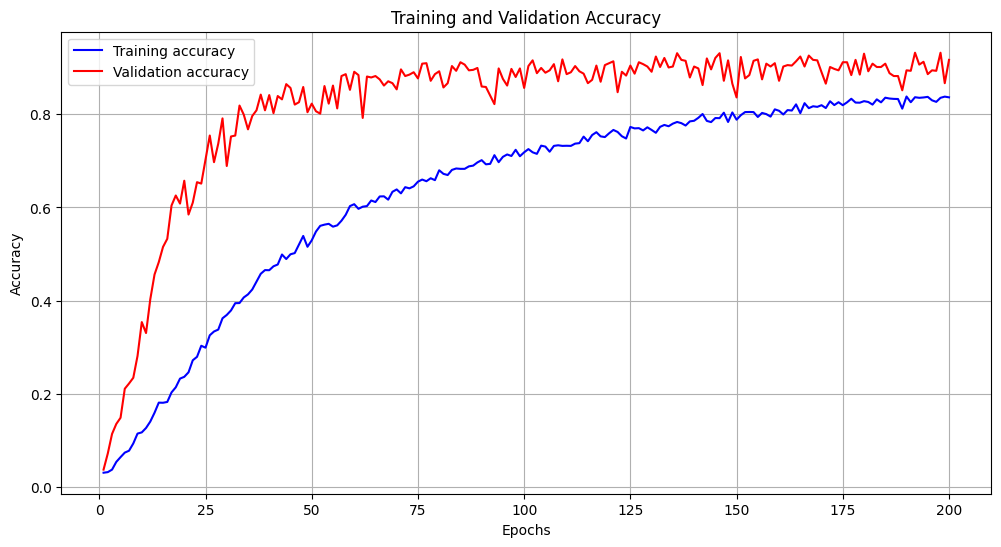

In [15]:
import matplotlib.pyplot as plt

# Extract accuracy data from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import os

# Define the path to save the model
model_save_path = '/kaggle/working/trained_model.h5'

# Save the model
try:
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Model saved to /kaggle/working/trained_model.h5


In [17]:
import os

# List files in the directory where the model is saved
print("Files in the save directory:", os.listdir('/kaggle/working'))

# Path to the folder inside /kaggle/input
test_dataset_dir = '/kaggle/input/braille-dataset-punjabi-in-png/image dataset/Organised_Testing_Set'

# List files in the test_dataset directory
files = os.listdir(test_dataset_dir)
print("Files in the test_dataset directory:", files)

Files in the save directory: ['.virtual_documents', 'trained_model.h5']
Files in the test_dataset directory: ['jhaja', 'Chachcha', 'thaththa', 'lalla', 'bhaba', 'rarra', 'babba', 'hahha', 'gagga', 'jajja', 'naana', 'phpha', 'dhada', 'nanna', 'naiaa', 'dada', 'nana', 'urha', 'Chcha', 'aara', 'kakka', 'thatha', 'ghaga', 'pappa', 'vava', 'khkha', 'tainka', 'jaiyaa', 'mamma', 'rarha', 'dhadha', 'sassa', 'dadda', 'tata', 'eeri']


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    directory=test_dataset_dir,
    target_size=(224, 224),
    color_mode='rgb',  # Change to 'rgb' for the VGG16 model
    batch_size=32,
    class_mode=None,  # Set to None for test data as we're only predicting
    shuffle=False,   # Do not shuffle test data
    seed=42
)

print("Test data generator created.")

Found 2100 images belonging to 35 classes.
Test data generator created.


In [19]:
from tensorflow.keras.models import load_model

# Path where the model was saved
model_path = '/kaggle/working/trained_model.h5'

# Load the trained model
model = load_model(model_path)

print("Model loaded successfully.")

Model loaded successfully.


In [24]:
# Define the path to your test dataset
test_directory = '/kaggle/input/braille-dataset-punjabi-in-png/image dataset/Organised_Testing_Set'

# Set up the ImageDataGenerator for the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),  # Use the same target size as for training and validation
    color_mode='rgb',  # Change to 'rgb' for the VGG16 model
    batch_size=32,
    class_mode='sparse',  # Assuming labels are provided for evaluation
    shuffle=False  # Set shuffle to False to keep the order of images
)



Found 2100 images belonging to 35 classes.


In [25]:
# Evaluate the model
def evaluate_model(model, test_generator):
    return model.evaluate(test_generator, verbose=1)

# Ensure eager execution
tf.config.run_functions_eagerly(True)

# Perform evaluation
try:
    test_loss, test_accuracy = evaluate_model(model, test_generator)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
except Exception as e:
    print(f"An error occurred during evaluation: {e}")

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.9161 - loss: 0.3123
Test Loss: 0.3177203834056854
Test Accuracy: 0.9114285707473755


In [33]:
# prediction on a single png file 

import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Define the path to the single PNG image you want to test
single_image_path = '/kaggle/input/test-it/eeri (9).png'

# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size, color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    return img_array

# Preprocess the image
preprocessed_image = load_and_preprocess_image(single_image_path)

# Make a prediction
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)
predicted_label = list(train_generator.class_indices.keys())[predicted_class[0]]

print(f"Predicted class label: {predicted_label}")
print(f"Predicted class index: {predicted_class[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class label: eeri
Predicted class index: 9
